In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import itertools
import time
import sys

from kesi._verbose import (VerboseFFR,
                           LinearMixture,
                           LoadableVerboseFFR)
from kesi._engine import _LinearKernelSolver
sys.path.append('..')
from FEM.fem_sphere_gaussian import (SomeSphereGaussianSourceFactory3D,
                                     SomeSphereGaussianSourceFactoryOnlyCSD)
from _common_new import altitude_azimuth_mesh

MeasurementManagerBase = VerboseFFR.MeasurementManagerBase

Unable to import from dolfin


In [2]:
class MeasurementManager(MeasurementManagerBase):
    def __init__(self, ELECTRODES, space='potential'):
        self._space = space
        self._ELECTRODES = ELECTRODES
        self.number_of_measurements = len(ELECTRODES)
    def probe(self, field):
        return getattr(field, 
                       self._space)(self._ELECTRODES.X,
                                    self._ELECTRODES.Y,
                                    self._ELECTRODES.Z)

In [3]:
def all_sources(r, altitude, azimuth):
    return [factory(x, y, z)
            for x, y, z in itertools.product(r, altitude, azimuth)]

In [4]:
def calculate_point_error(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction at every point of
    estimation space separetly.

    Parameters
    ----------
    true_csd: numpy array
        Values of true csd at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.

    Returns
    -------
    point_error: numpy array
        Normalized error of reconstruction calculated separetly at every
        point of estimation space.
    """
    true_csd_r = true_csd.reshape(true_csd.size, 1)
    est_csd_r = est_csd.reshape(est_csd.size, 1)
    epsilon = np.linalg.norm(true_csd_r)/np.max(abs(true_csd_r))
    err_r = abs(est_csd_r/(np.linalg.norm(est_csd_r)) -
                true_csd_r/(np.linalg.norm(true_csd_r)))
    err_r *= epsilon
    point_error = err_r.reshape(true_csd.shape)
    return point_error

In [5]:
def calculate_rms(true_csd, est_csd):
    """
    Calculates normalized error of reconstruction.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rms: float
        Normalized error of reconstruction.
    """
    rms = np.linalg.norm((true_csd - est_csd))/(np.linalg.norm(true_csd))
    return rms

In [6]:
def calculate_rdm(true_csd, est_csd):
    """
    Calculates relative difference measure between reconstructed source and
    ground truth.
    Parameters
    ----------
    true_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    rdm: float
        Relative difference measure.
    """
    epsilon = np.finfo(np.float64).eps
    rdm = np.linalg.norm(est_csd/(np.linalg.norm(est_csd) + epsilon) -
                         true_csd/(np.linalg.norm(true_csd) + epsilon))
    return rdm

In [7]:
def calculate_rdm_point(true_csd, est_csd):
    rdm = abs(est_csd.reshape(est_csd.size, 1)/(np.linalg.norm(est_csd.reshape(est_csd.size, 1))) -
              true_csd.reshape(true_csd.size, 1)/(np.linalg.norm(true_csd.reshape(true_csd.size, 1))))
    rdm *= np.linalg.norm(true_csd.reshape(true_csd.size, 1))/np.max(abs(true_csd.reshape(true_csd.size, 1)))
    return rdm.reshape(true_csd.shape)

In [8]:
def calculate_mag(true_csd, est_csd):
    """
    Calculates magnitude ratio between reconstructed source and ground
    truth.
    Parameters
    ----------
    test_csd: numpy array
        Values of true CSD at points of kCSD estimation.
    est_csd: numpy array
        CSD estimated with kCSD method.
    Returns
    -------
    mag: float
        Magnitude ratio.
    """
    epsilon = np.finfo(np.float64).eps
    mag = np.linalg.norm(est_csd/(true_csd + epsilon))
    return mag

In [9]:
def calculate_mag_point(true_csd, est_csd):
    epsilon = np.max(abs(true_csd.reshape(true_csd.size, 1)))
    mag = abs(est_csd.reshape(est_csd.size, 1))/(abs(true_csd.reshape(true_csd.size, 1)) + epsilon)
    return mag.reshape(true_csd.shape)

In [10]:
def cross_validate(reconstructor, measurements, regularization_parameters):
    errors = np.zeros(regularization_parameters.size)
    for rp_idx, rp in enumerate(regularization_parameters):
        print('Cross validating regularization parameter :', rp)
        errors[rp_idx] = np.linalg.norm(reconstructor.leave_one_out_errors(measurements, rp))
    err_idx = np.where(errors == np.min(errors))
    cv_rp = regularization_parameters[err_idx][0]
    print('CV_rp :', cv_rp)
    return cv_rp, errors

In [57]:
def make_plot(values, val_type, X, Y, Z, path, idx=15, fig_title=None):
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111)
    ax.set_title(fig_title)
    if val_type == 'csd':
        cmap = cm.bwr
        t_max = np.max(np.abs(values))
        t_min = -t_max
    else:
        cmap = cm.Greys
        t_max = np.max(np.abs(values))#1
        t_min = 0
    levels = np.linspace(t_min, t_max, 65)
    ax.set_aspect('equal')
    im = ax.contourf(X[:, :, idx], Y[:, :, idx], values[:, :, idx], levels=levels, cmap=cmap, alpha=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_xticks([X.min(), 0, X.max()])
    ax.set_yticks([Z.min(), 0, Z.max()])
    ticks = np.linspace(t_min, t_max, 3, endpoint=True)
    plt.colorbar(im, orientation='horizontal', format='%.2f', ticks=ticks)
    plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)
    return

In [28]:
def values_in_a_grid(X, values, IDX):
    VALUES = np.zeros(X.shape)  
    for v, i, j, k in zip(values, *np.where(IDX)):  # place values in regular grid
        VALUES[i, j, k] = v
    return VALUES

In [58]:
def generate_figure(X, Y, Z, values, values_type, IDX, layer, title, save_path=sys.path[0]):
    VALUES = values_in_a_grid(X, values, IDX)
    make_plot(VALUES, values_type, X, Y, Z, save_path, idx=layer, fig_title=title)

In [102]:
def make_subplot(ax, values, val_type, X, Y, Z, t_max, idx=15, fig_title=None, colorbar=False, cax=None):
    #plt.figure(figsize=(6, 6))
    #ax = plt.subplot(111)
    ax.set_title(fig_title)
    if val_type == 'csd':
        cmap = cm.bwr
        #t_max = np.max(np.abs(values))
        t_min = -t_max
    else:
        cmap = cm.Greys
        #t_max = np.max(np.abs(values))#1
        t_min = 0
    levels = np.linspace(t_min, t_max, 65)
    ax.set_aspect('equal')
    im = ax.contourf(X[:, :, idx], Y[:, :, idx], values[:, :, idx], levels=levels, cmap=cmap, alpha=1)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)', labelpad=0.04)
    ax.set_xticks([X.min(), 0, X.max()])
    ax.set_yticks([Z.min(), 0, Z.max()])
    if colorbar:
        ticks = np.linspace(t_min, t_max, 3, endpoint=True)
        plt.colorbar(im, cax=cax, orientation='horizontal', format='%.0e', ticks=ticks)
    #plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)
    return

In [60]:
def generate_subplot(X, Y, Z, true_csd, est_csd1, type1, est_csd2, type2, IDX, layer, fig_title, src_nr=0, save_path=sys.path[0]):
    fig = plt.figure(figsize=(17, 15))
    csd_max = 60000
    err_max = 0.14
    gs = gridspec.GridSpec(4, 3, height_ratios=[1., 1., 1., 0.04], left=0.135,
                           right=0.865, top=0.94, bottom=0.06)
    TRUE_CSD = values_in_a_grid(X, true_csd[src_nr], IDX)
    ax = plt.subplot(gs[0, 0])
    title = 'True csd'
    make_subplot(ax, TRUE_CSD, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title)
    
    EST_CSD1 = values_in_a_grid(X, est_csd1[src_nr], IDX)
    ax = plt.subplot(gs[1, 0])
    title = 'Est csd ' + str(type1)
    make_subplot(ax, EST_CSD1, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title)
    
    error1 = calculate_point_error(true_csd[src_nr], est_csd1[src_nr])
    ERROR1 = values_in_a_grid(X, error1, IDX)
    ax = plt.subplot(gs[1, 1])
    title = 'Error ' + str(type1)
    make_subplot(ax, ERROR1, 'err', X, Y, Z, err_max, idx=layer, fig_title=title)
    
    diff1 = (true_csd[src_nr] - est_csd1[src_nr])
    DIFF1 = values_in_a_grid(X, diff1, IDX)
    ax = plt.subplot(gs[1, 2])
    title = 'Diff ' + str(type1)
    make_subplot(ax, DIFF1, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title)
    
    EST_CSD2 = values_in_a_grid(X, est_csd2[src_nr], IDX)
    ax = plt.subplot(gs[2, 0])
    cax = plt.subplot(gs[3, 0])
    title = 'Est csd ' + str(type2)
    make_subplot(ax, EST_CSD2, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    error2 = calculate_point_error(true_csd[src_nr], est_csd2[src_nr])
    ERROR2 = values_in_a_grid(X, error2, IDX)
    ax = plt.subplot(gs[2, 1])
    cax = plt.subplot(gs[3, 1])
    title = 'Error ' + str(type2)
    make_subplot(ax, ERROR2, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    diff2 = (true_csd[src_nr] - est_csd2[src_nr])
    DIFF2 = values_in_a_grid(X, diff2, IDX)
    ax = plt.subplot(gs[2, 2])
    cax = plt.subplot(gs[3, 2])
    title = 'Diff ' + str(type2)
    make_subplot(ax, DIFF2, 'csd', X, Y, Z, csd_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    fig_title = fig_title + ' validation ' + type1 + type2 + ' src_nr ' + str(src_nr)
    print(fig_title)
    plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)

In [15]:
start_time = time.time()    
MESHFILE = '/home/mbejtka/Data_Kuba/four_spheres_gaussian_1000_deg_1.npz'
factory = SomeSphereGaussianSourceFactory3D(MESHFILE)
print("Loading data --- %s seconds ---" % (time.time() - start_time))

dst = factory.R[1] - factory.R[0]
sources = [factory(r, altitude, azimuth)
           for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
           for r in factory.R]
print('Number of sources: ', len(sources))
print("Sources --- %s seconds ---" % (time.time() - start_time))

Loading data --- 2.5657429695129395 seconds ---
Number of sources:  45508
Sources --- 6.828580617904663 seconds ---


In [16]:
# Determine positions of electrodes
theta, phi, r = np.meshgrid(np.linspace(-0.5*np.pi, 0.5*np.pi, 15),
                           np.linspace(0, 2*np.pi, 15),
                           [factory.R.max()])
ELE_X = r*np.cos(theta)*np.cos(phi)
ELE_Y = r*np.cos(theta)*np.sin(phi)
ELE_Z = r*np.sin(theta)
ELECTRODES = pd.DataFrame({'X': ELE_X.flatten(),
                           'Y': ELE_Y.flatten(),
                           'Z': ELE_Z.flatten()})

In [17]:
# Estimating points    
r = factory.scalp_radius
X, Y, Z = np.meshgrid(np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30),
                      np.linspace(-r, r, 30))
IDX = X**2 + Y**2 + Z**2 <=r**2
EST_X = X[IDX]
EST_Y = Y[IDX]
EST_Z = Z[IDX]
EST_POINTS =pd.DataFrame({'X': EST_X.flatten(),
                          'Y': EST_Y.flatten(),
                          'Z': EST_Z.flatten()})

In [18]:
measurement_manager = MeasurementManager(ELECTRODES, space='potential')
measurement_manager_basis = MeasurementManager(EST_POINTS, space='csd')

In [19]:
# Create reconstructor
reconstructor_filename = '../SavedReconstructor_four_spheres_1000_deg_1.npz'
#reconstructor = VerboseFFR(sources, measurement_manager)
#reconstructor.save(reconstructor_filename)
#print("Reconstructor --- %s seconds ---" % (time.time() - start_time))

In [20]:
factoryCSD = SomeSphereGaussianSourceFactoryOnlyCSD(MESHFILE)
dst = factoryCSD.R[1] - factoryCSD.R[0]
sourcesCSD = [factoryCSD(r, altitude, azimuth)
              for altitude, azimuth in altitude_azimuth_mesh(-np.pi/2,
                                                          dst/factory.scalp_radius)
              for r in factoryCSD.R]

In [21]:
loadable_reconstructor = LoadableVerboseFFR(reconstructor_filename, sourcesCSD, measurement_manager)
kernel = loadable_reconstructor.kernel
cross_rec_filename = 'results/four_spheres_1000_deg_1_cross_reconstructor.npz'
cross_kernel = loadable_reconstructor.get_kernel_matrix(measurement_manager_basis)
#cross_kernel = loadable_reconstructor._CrossKernelReconstructor.load(cross_rec_filename)
cross_reconstructor = loadable_reconstructor._CrossKernelReconstructor(_LinearKernelSolver(kernel), cross_kernel)

In [136]:
cross_reconstructor = loadable_reconstructor._CrossKernelReconstructor(_LinearKernelSolver(kernel), cross_kernel)

In [71]:
cross_kernel = loadable_reconstructor.get_kernel_matrix(measurement_manager_basis)

In [22]:
potential = [measurement_manager.probe(source) for source in sources]

In [23]:
true_csd = [measurement_manager_basis.probe(source) for source in sourcesCSD]

In [24]:
with np.load('../four_spheres_parallel_1000_deg_1_rp_0.npz') as fh:
    EST_CSD_RP0 = fh['EST_CSD']

In [25]:
with np.load('results/four_spheres_1000_deg_1_cv.npz') as fh:
    EST_CSD_CV = fh['EST_CSD']

In [26]:
with np.load('../four_spheres_1000_deg_1_rp_001.npz') as fh:
    EST_CSD_PIC = fh['EST_CSD']

four_spheres validation PicardCV src_nr 0


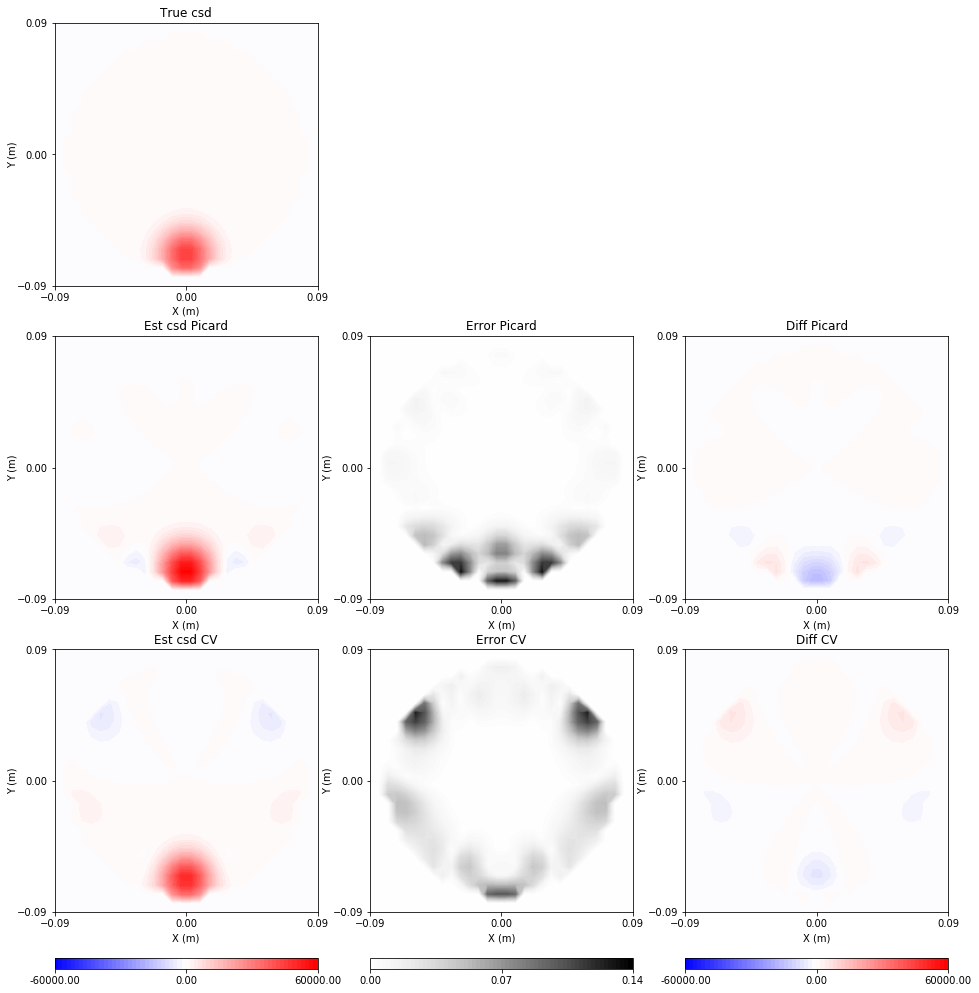

In [61]:
src_nr = 0
layer = 15
sphere = 'four_spheres'
path = sys.path[0]
generate_subplot(X, Y, Z, true_csd, EST_CSD_PIC, 'Picard', EST_CSD_CV, 'CV', IDX, layer, str(sphere), src_nr, path)

In [62]:
def generate_reliability_maps(X, Y, Z, true_csd, est_csd, IDX, layer, fig_title, path):
    fig = plt.figure(figsize=(17, 6))
    gs = gridspec.GridSpec(2, 3, height_ratios=[1., 0.04], width_ratios=[1]*3)
    error_kCSD_pts = np.array([calculate_point_error(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
    error_kCSD = np.mean(error_kCSD_pts, axis=0)
    error_rdm_pts = np.array([calculate_rdm_point(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
    error_rdm = np.mean(error_rdm_pts, axis=0)
    error_mag_pts = np.array([calculate_mag_point(t_csd, e_csd) for t_csd, e_csd in zip(true_csd, est_csd)])
    error_mag = np.mean(error_mag_pts, axis=0)
    err_max = np.max(np.array([np.max(error_kCSD), np.max(error_rdm), np.max(error_mag)]))
    
    ax = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[1, 0])
    ERROR_kCSD = values_in_a_grid(X, error_kCSD, IDX)
    title = 'Error kCSD'
    make_subplot(ax, ERROR_kCSD, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 1])
    cax = plt.subplot(gs[1, 1])
    ERROR_rdm = values_in_a_grid(X, error_rdm, IDX)
    title = 'Error rdm'
    make_subplot(ax, ERROR_rdm, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 2])
    cax = plt.subplot(gs[1, 2])
    ERROR_mag = values_in_a_grid(X, error_mag, IDX)
    title = 'Error mag'
    make_subplot(ax, ERROR_mag, 'err', X, Y, Z, err_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)
    return

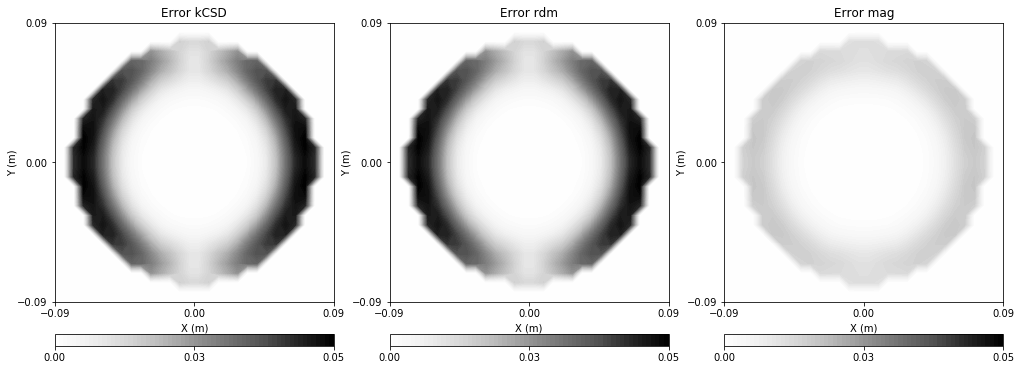

In [65]:
fig_title = str(sphere) + '_ReliabilityMaps_Picard'
generate_reliability_maps(X, Y, Z, true_csd, EST_CSD_PIC, IDX, layer, fig_title, path)

In [66]:
def calculate_eigensources(kernel, cross_kernel, regularization_parameter=0):
    eigenvalues, eigenvectors = np.linalg.eigh(kernel + np.identity(kernel.shape[0])
                                               * regularization_parameter)
    return np.matmul(cross_kernel, eigenvectors), eigenvalues, eigenvectors

In [67]:
def csd_into_eigensource_projection(csd, eigensources):
    orthn = scipy.linalg.orth(eigensources)
    return np.matmul(np.matmul(csd, orthn), orthn.T)

In [74]:
eigensources, eigenvalues, eigenvectors = calculate_eigensources(kernel, cross_kernel, regularization_parameter=0)

In [69]:
kernel.shape

(225, 225)

In [73]:
cross_kernel.shape

(12712, 225)

In [105]:
def generate_eigensource_subplot(X, Y, Z, eigensources, IDX, layer, fig_title, path):
    #t_max = np.max(abs(eigensources))
    fig = plt.figure(figsize=(18, 16))
    gs = gridspec.GridSpec(6, 4, height_ratios=[1., 0.04, 1., 0.04, 1., 0.04], width_ratios=[1]*4)
    
    ax = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[1, 0])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -1], IDX)
    title = 'Eigensource 1'
    t_max = np.max(abs(eigensources[:, -1]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 1])
    cax = plt.subplot(gs[1, 1])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -2], IDX)
    title = 'Eigensource 2'
    t_max = np.max(abs(eigensources[:, -2]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 2])
    cax = plt.subplot(gs[1, 2])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -3], IDX)
    title = 'Eigensource 3'
    t_max = np.max(abs(eigensources[:, -3]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 3])
    cax = plt.subplot(gs[1, 3])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -4], IDX)
    title = 'Eigensource 4'
    t_max = np.max(abs(eigensources[:, -4]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 0])
    cax = plt.subplot(gs[3, 0])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -5], IDX)
    title = 'Eigensource 5'
    t_max = np.max(abs(eigensources[:, -5]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 1])
    cax = plt.subplot(gs[3, 1])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -6], IDX)
    title = 'Eigensource 6'
    t_max = np.max(abs(eigensources[:, -6]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 2])
    cax = plt.subplot(gs[3, 2])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -7], IDX)
    title = 'Eigensource 7'
    t_max = np.max(abs(eigensources[:, -7]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[2, 3])
    cax = plt.subplot(gs[3, 3])
    EIGENSRC = values_in_a_grid(X, eigensources[:, -8], IDX)
    title = 'Eigensource 8'
    t_max = np.max(abs(eigensources[:, -8]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 0])
    cax = plt.subplot(gs[5, 0])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 3], IDX)
    title = 'Eigensource 252'
    t_max = np.max(abs(eigensources[:, 3]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 1])
    cax = plt.subplot(gs[5, 1])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 2], IDX)
    title = 'Eigensource 253'
    t_max = np.max(abs(eigensources[:, 2]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 2])
    cax = plt.subplot(gs[5, 2])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 1], IDX)
    title = 'Eigensource 254'
    t_max = np.max(abs(eigensources[:, 1]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[4, 3])
    cax = plt.subplot(gs[5, 3])
    EIGENSRC = values_in_a_grid(X, eigensources[:, 0], IDX)
    title = 'Eigensource 255'
    t_max = np.max(abs(eigensources[:, 0]))
    make_subplot(ax, EIGENSRC, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)

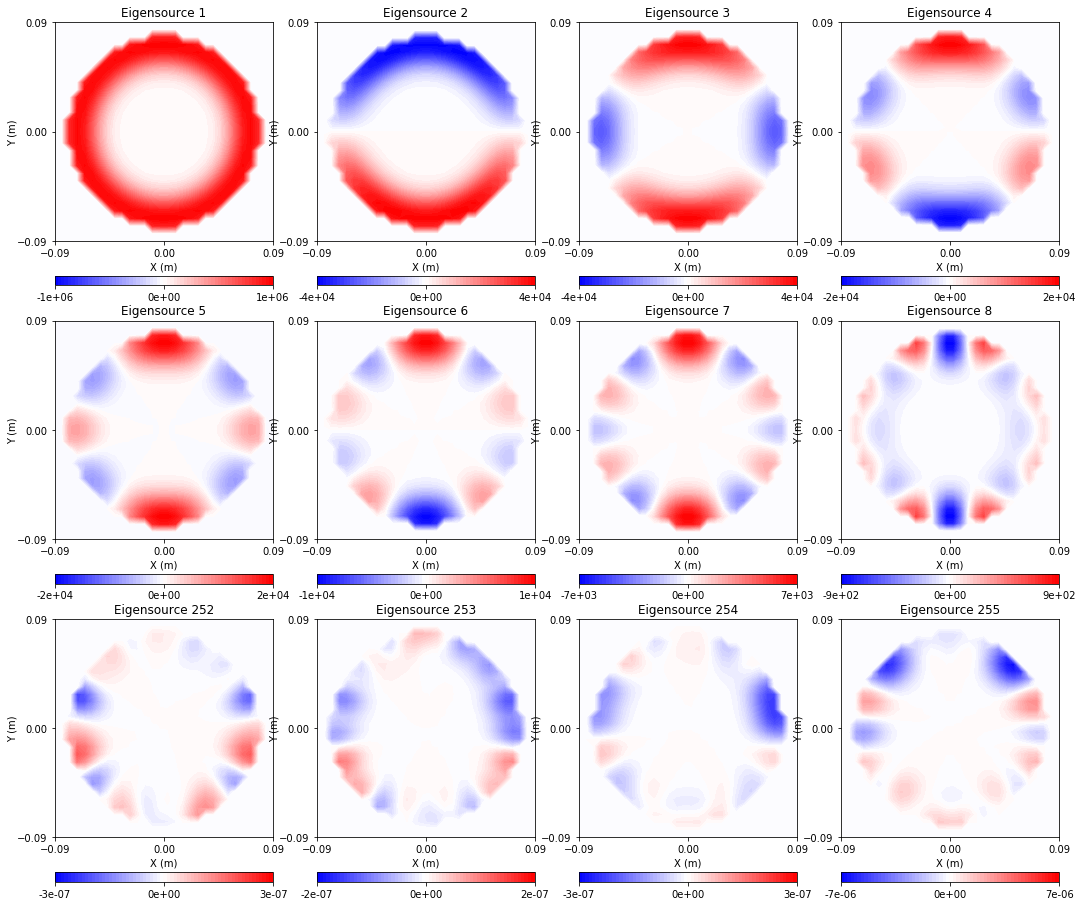

In [106]:
generate_eigensource_subplot(X, Y, Z, eigensources, IDX, layer, str(sphere)+'_Eigensources_different_scales', path)

In [117]:
def generate_projection_subplot(X, Y, Z, true_csd, est_csd, eigensources, IDX, layer, fig_title, path):
    #t_max = np.max(abs(eigensources))
    fig = plt.figure(figsize=(17, 6))
    gs = gridspec.GridSpec(2, 4, height_ratios=[1., 0.04], width_ratios=[1]*4)
    
    ax = plt.subplot(gs[0, 0])
    cax = plt.subplot(gs[1, 0])
    TRUE_CSD = values_in_a_grid(X, true_csd, IDX)
    title = 'True CSD'
    t_max = np.max(abs(true_csd))
    make_subplot(ax, TRUE_CSD, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 1])
    cax = plt.subplot(gs[1, 1])
    EST_CSD = values_in_a_grid(X, est_csd, IDX)
    title = 'Est CSD'
    t_max = np.max(abs(est_csd))
    make_subplot(ax, EST_CSD, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 2])
    cax = plt.subplot(gs[1, 2])
    projection = csd_into_eigensource_projection(true_csd, eigensources)
    PROJECTION = values_in_a_grid(X, projection, IDX)
    title = 'CSD Projection on eigensources space'
    t_max = np.max(abs(projection))
    make_subplot(ax, PROJECTION, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    ax = plt.subplot(gs[0, 3])
    cax = plt.subplot(gs[1, 3])
    DIFF = values_in_a_grid(X, (true_csd-est_csd), IDX)
    title = 'Anihilator'
    t_max = np.max(abs(est_csd))
    make_subplot(ax, DIFF, 'csd', X, Y, Z, t_max, idx=layer, fig_title=title, colorbar=True, cax=cax)
    
    plt.savefig(path + '/figs/' + str(fig_title) +'.png', dpi=300)

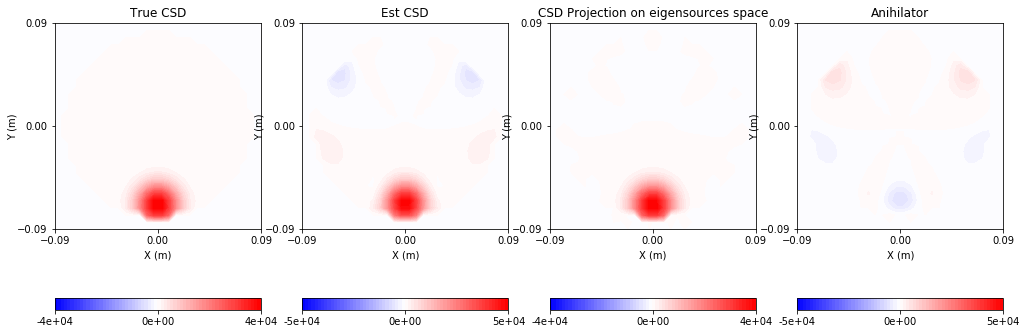

In [118]:
generate_projection_subplot(X, Y, Z, true_csd[0], EST_CSD_CV[0], eigensources, IDX, layer, str(sphere)+'_Projection', path)

In [153]:
def picard_plot_log(ax, eigenvalues, eigenvectors, potential, sphere, src_nr, save_path):
    #idx = eigenvalues.argsort()[::-1]
    #eigenvalues = eigenvalues[idx]
    #eigenvectors = eigenvectors[:, idx]
    utb = abs(np.matmul(eigenvectors.T, potential))
    utbs = abs(np.matmul(eigenvectors.T, potential))/eigenvalues
    #plt.figure(figsize=(8, 5))
    ax.set_title('Picard plot')
    ax.plot(eigenvalues, eigenvalues, '.', label=r'$\mu^{\frac{1}{2}}$')
    ax.plot(eigenvalues, utb, label='$|W^{T}V|$')
    ax.plot(eigenvalues, utbs, label=r'$\frac{|W^{T}V|}{\mu^{\frac{1}{2}}}$')
    #plt.axvline(x=21, linestyle='--', color='black', label='cut-off')
    ax.set_yscale('log')
    ax.set_xlabel('Eigenvalues')
    ax.set_xscale('log')
    ax.legend(ncol=4)
    #plt.savefig(save_path +'/figs/Picard_plot_log '+str(sphere)+' 1000_pots_' + str(src_nr) + '.png', dpi=300)
    #plt.show()

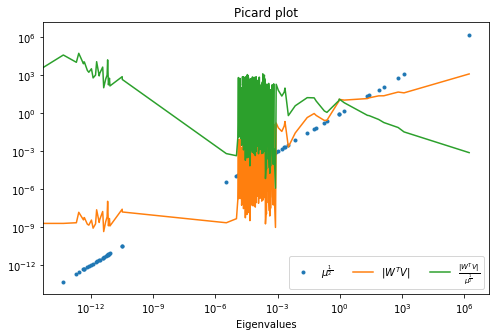

In [129]:
picard_plot_log(eigenvalues, eigenvectors, potential[0], sphere, src_nr, path)

In [137]:
rp, cv_errors = cross_validate(cross_reconstructor, potential[src_nr], eigenvalues)

Cross validating regularization parameter : -5.318938604565034e-11
Cross validating regularization parameter : -7.333566873929422e-12
Cross validating regularization parameter : -6.9394533029877176e-12
Cross validating regularization parameter : -4.930050839178285e-12
Cross validating regularization parameter : -4.725608658359631e-12
Cross validating regularization parameter : -3.303612787793311e-12
Cross validating regularization parameter : -3.0044716216289734e-12
Cross validating regularization parameter : -2.84240036016168e-12
Cross validating regularization parameter : -1.878105781795782e-12
Cross validating regularization parameter : -1.857056427043698e-12
Cross validating regularization parameter : -1.483357043976118e-12
Cross validating regularization parameter : -1.0919796911643352e-12
Cross validating regularization parameter : -8.884811462937921e-13
Cross validating regularization parameter : -6.92195824330563e-13
Cross validating regularization parameter : -5.69132598302780

Cross validating regularization parameter : 8.890403589155464e-05
Cross validating regularization parameter : 8.954206763612086e-05
Cross validating regularization parameter : 9.129633031515532e-05
Cross validating regularization parameter : 9.221557530400875e-05
Cross validating regularization parameter : 9.93745556523601e-05
Cross validating regularization parameter : 9.955542503540675e-05
Cross validating regularization parameter : 0.00010029962522272324
Cross validating regularization parameter : 0.00010072067866111144
Cross validating regularization parameter : 0.00011077853358385947
Cross validating regularization parameter : 0.00011116473991419622
Cross validating regularization parameter : 0.00011161349827979106
Cross validating regularization parameter : 0.00011275860186628598
Cross validating regularization parameter : 0.00011313066035038929
Cross validating regularization parameter : 0.00011727170880458127
Cross validating regularization parameter : 0.00011835029571096966
Cr

In [187]:
def plot_cv_errors(ax, rps, rp_errors, sphere, src_nr, save_path):
    #plt.figure(figsize=(6, 4))
    #ax.set_title(sphere)
    ax.plot(rp_errors, '.')
    #ax.plot(rps, rp_errors, '.')
    #ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Regularization parameter')
    ax.set_ylabel('Error in potential space')
    #plt.savefig(save_path + '/figs/cv_errors ' + sphere + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

In [178]:
len(eigenvalues)

225

In [175]:
plot_cv_errors(eigenvalues, cv_errors, sphere, src_nr, path)

TypeError: plot_cv_errors() missing 1 required positional argument: 'save_path'

In [140]:
rms = np.zeros(len(eigenvalues))
rdm = np.zeros(len(eigenvalues))
mag = np.zeros(len(eigenvalues))
for j, value in enumerate(eigenvalues):
    est_csd_ev = cross_reconstructor(potential[src_nr], np.array(value))
    rms[j] = calculate_rms(true_csd[src_nr], est_csd_ev)
    rdm[j] = calculate_rdm(true_csd[src_nr], est_csd_ev)
    mag[j] = calculate_mag(true_csd[src_nr], est_csd_ev)

In [190]:
def plot_global_csd_errors(ax, rps, rms, rdm, mag, sphere, src_nr, save_path, title):
    #plt.figure(figsize=(6, 4))
    #ax.set_title(sphere + title)
    ax.plot(rps, rms, '.', label='RMS')
    ax.plot(rps, rdm, '.', label='RDM')
    #ax.plot(rps, mag, '.', label='RMAG')
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_xlabel('Component number')
    ax.set_ylabel('Error in csd space')
    ax.legend()
    #plt.savefig(save_path + '/figs/' + sphere + title + '1000_deg_1 src_'+  str(src_nr) + '.png', dpi=300)

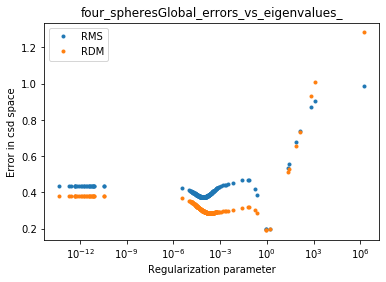

In [147]:
plot_global_csd_errors(eigenvalues,rms, rdm, mag, sphere, src_nr, path, 'Global_errors_vs_eigenvalues_')

In [183]:
def picard_plot(ax, eigenvalues, eigenvectors, potential, sphere, number, save_path):
    utb = abs(np.matmul(eigenvectors.T, potential))
    utbs = abs(np.matmul(eigenvectors.T, potential))/eigenvalues
    #plt.figure(figsize=(8, 5))
    ax.set_title('Picard plot')
    ax.plot(eigenvalues, '.', label=r'$\mu^{\frac{1}{2}}$')
    ax.plot(utb, label='$|W^{T}V|$')
    ax.plot(utbs, label=r'$\frac{|W^{T}V|}{\mu^{\frac{1}{2}}}$')
    #plt.axvline(x=21, linestyle='--', color='black', label='cut-off')
    ax.set_yscale('log')
    ax.set_xlabel('Component number')
    ax.legend(ncol=4)
    #plt.savefig(save_path +'/Picard_plot '+str(sphere)+' 1000_pots_' + str(number) + '.png', dpi=300)
    #plt.show()

In [191]:
def generate_Picard_subplot(eigenvalues, eigenvectors, potential, cv_errors, rms, rdm, mag, sphere, src_nr, path):
    plt.figure(figsize=(10, 8))
    
    ax = plt.subplot(221)
    picard_plot(ax, eigenvalues, eigenvectors, potential, sphere, src_nr, path)
    
    ax = plt.subplot(222)
    picard_plot_log(ax, eigenvalues, eigenvectors, potential, sphere, src_nr, path)
    
    ax = plt.subplot(223)
    plot_cv_errors(ax, eigenvalues, cv_errors, sphere, src_nr, path)
    
    ax = plt.subplot(224)
    plot_global_csd_errors(ax, eigenvalues, rms, rdm, mag, sphere, src_nr, path, '')
    
    plt.savefig(path +'/figs/Picard_diagnostics_ '+str(sphere)+' 1000_pots_' + str(src_nr) + '.png', dpi=300)

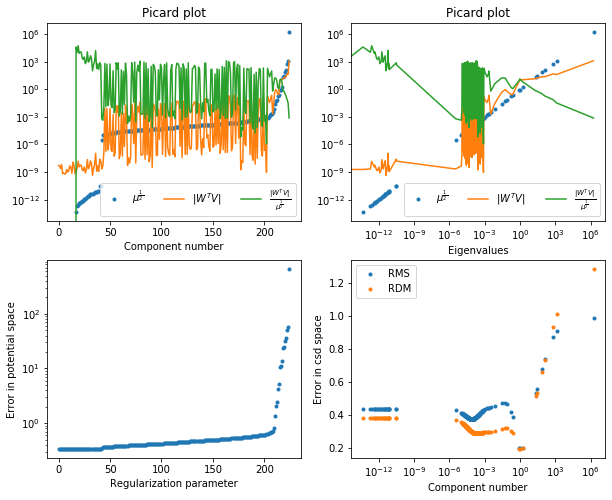

In [192]:
generate_Picard_subplot(eigenvalues, eigenvectors, potential[src_nr], cv_errors, rms, rdm, mag, sphere, src_nr, path)